# Kalman Filter

Let's study the Kalman Filter based on [KalmanFilter.NET](https://www.kalmanfilter.net/) <cite data-cite="2018:becker"></cite>. 

## Weighting Gold

This example is from the $\alpha$ - $\beta$ - $\gamma$ [tutorial](https://www.kalmanfilter.net/alphabeta.html#ex1). In this example, we are weighting a gold bar, whose true weight is 1010 g. To start off, our final estimate $\hat{x}_{N,N}$ of the gold bar should be the average of all our measurements $z_n$.

$\hat{x}_{N,N} = \frac{1}{N} \sum z_n$

where

- $N$ is the number of measurements taken and can also be taken to mean time points
- $z_n$ is the measurement taken at time $n$
- $\hat{x}_{N,N}$ is the estimation of the weight based on all the measurements

This equation is fine if we want to take many measurements and then compute the final estimate in one swoop at the end. However, the Kalman Filter is meant to estimate the gold bar weight in real time. The `State Update Equation` provides the formula for estimating the gold bar weight **as we take measurements** (as opposed to one time only at the very end). The `State Update Equation` is written as follows.

$\hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha_n (z_n - \hat{x}_{n,n-1})$

- $x$ is the true value of the weight
- $z_n$ is the measurement at time $n$
- $\hat{x}_{n,n}$ is the estimate of $x$ at time $n$
- $\hat{x}_{n,n-1}$ is the previous estimate of $x$ at time $n-1$
- $\hat{x}_{n+1,n}$ is the next estimate of $x$ at time $n+1$
- $\alpha_n$ is called the `Kalman Gain`
- $(z_n - \hat{x}_{n,n-1})$ is called the `innovation`

$\alpha_n$ decreases as the number of iteration (measurements over time) grows, thereby weighting down the measurements $z_n$. Since the dynamic state of the system is constant (the gold weight does not change), $\hat{x}_{n+1,n} = \hat{x}_{n,n}$.

Below, is how we use the `State Update Equation` to estimate the gold bar weight over 10 measurements (in *real-time*).

In [1]:
import pandas as pd

measurements = [1030, 989, 1017, 1009, 1013, 979, 1008, 1042, 1012, 1011]
estimates = []
iters = []
x_ij = 1000

for i, z_i in enumerate(measurements):
    n = i + 1
    alpha_i = 1 / n
    x_ii = x_ij + alpha_i * (z_i - x_ij)
    x_ij = x_ii
    
    iters.append(n)
    estimates.append(x_ii)
    
measurements = pd.Series(measurements, index=iters)
estimates = pd.Series(estimates, index=iters)

Let's plot the measurements, estimations and true gold bar weight.

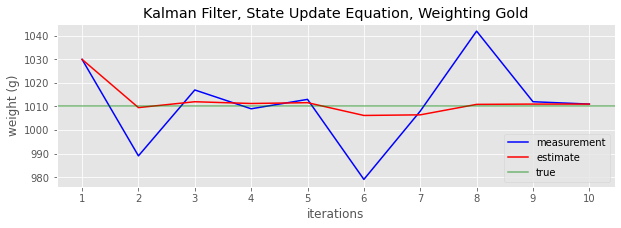

In [2]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(37)
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 3))

_ = measurements.plot(kind='line', ax=ax, color='blue', label='measurement')
_ = estimates.plot(kind='line', ax=ax, color='red', label='estimate')
_ = ax.axhline(1010, color='green', alpha=0.5, label='true')
_ = ax.set_xticks(range(1, len(measurements) + 1))
_ = ax.set_xticklabels(measurements.index)
_ = ax.legend()
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('weight (g)')
_ = ax.set_title('Kalman Filter, State Update Equation, Weighting Gold')

We can sample the gold weight from $\mathcal{N}(1010, 18)$ 1,000 times and apply the Kalman filter. This sampling from the normal distribution $\mathcal{N}(1010, 18)$ simulates the situation as if we were sequentially taking many measurements.

In [3]:
measurements = np.random.normal(1010, 18, 1000)
estimates = []
iters = []
x_ij = 1000

for i, z_i in enumerate(measurements):
    n = i + 1
    alpha_i = 1 / n
    x_ii = x_ij + alpha_i * (z_i - x_ij)
    x_ij = x_ii
    
    iters.append(n)
    estimates.append(x_ii)
    
measurements = pd.Series(measurements, index=iters)
estimates = pd.Series(estimates, index=iters)

Here, we will plot the measurement, estimate and true values over time. The measurements bounces up and down, but the estimations tend to converge to the true value.

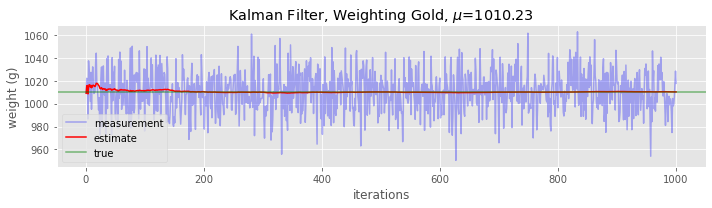

In [4]:
fig, ax = plt.subplots(figsize=(10, 3))

_ = measurements.plot(kind='line', ax=ax, color='blue', alpha=0.3, label='measurement')
_ = estimates.plot(kind='line', ax=ax, color='red', label='estimate')
_ = ax.axhline(1010, color='green', alpha=0.5, label='true')
_ = ax.legend()
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('weight (g)')
_ = ax.set_title(fr'Kalman Filter, Weighting Gold, $\mu$={measurements.mean():.2f}')

plt.tight_layout()

Here, we plot the mean absolute error `MAE` and standard deviation of the MAE. Demote $w_t$ as the true weight and $w_e$ as the estimated weight, then $|w_t - w_e|$ is the absolute error. The MAE is the average over these absolute errors. As we take more and more measurements, the absolute error tends to zero.

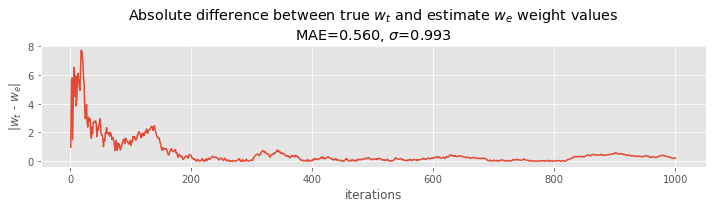

In [5]:
fig, ax = plt.subplots(figsize=(10, 3))

ae = np.abs(estimates - 1010)
mae = ae.mean()
std = ae.std()

_ = ae.plot(kind='line', ax=ax)
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel(r'|$w_t$ - $w_e$|')
_ = ax.set_title(r'Absolute difference between true $w_t$ and estimate $w_e$ weight values' + 
                 '\n' + 
                 rf'MAE={mae:.3f}, $\sigma$={std:.3f}')

plt.tight_layout()

## Tracking aircraft, constant velocity

In this [second example](https://www.kalmanfilter.net/alphabeta.html#ex2), we are tracking the position of an aircraft with a constant velocity. In the previous example, the gold weight did not change; *the dynamic state of the system was constant*. Here, the dynamic state of the system changes over time, namely, the position (although the velocity is constant).

How do we estimate the next position?

$\hat{x}_{n+1,n} = \hat{x}_{n,n} + \Delta{t} v_{n,n}$

where

- $\hat{x}_{n,n}$ is the estimated position in the current time step
- $\hat{x}_{n+1,n}$ is the estimated position in the next time step
- $\Delta{t}$ is duration (of time, e.g. in seconds; the example sets this to 5)
- $v_{n,n}$ is the velocity

Conceptually, where the position of the aircraft will be next depends on where it was plus the time multiplied by the velocity. We also need to estimate the next velocity too. (We diverge from the original article's notation).

$\hat{v}_{n+1,n} = \hat{v}_{n,n}$

Since velocity is constant, the estimation of the next velocity is the same as the previous (the example sets velocity to 40 m/s). The two equations above are rewritten below, and are called the `State Extrapolation Equations`.

- $\hat{x}_{n+1,n} = \hat{x}_{n,n} + \Delta{t} v_{n,n}$
- $\hat{v}_{n+1,n} = \hat{v}_{n,n}$

How do we update the position and velocity? The State Update Equation for position is as follows.

$\hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha (z_n - \hat{x}_{n,n-1}) = \hat{x}_{n,n-1} + \alpha \Delta{x}$

The State Update Equation for velocity is as follows. 

$\hat{v}_{n,n} = \hat{v}_{n,n-1} + \beta \frac{z_n - \hat{x}_{n,n-1}}{\Delta{t}} = \hat{v}_{n,n-1} + \beta \frac{\Delta{x}}{\Delta{t}}$

The weighting parameters $\alpha$ and $\beta$ do not change in this example. The meaning of $\alpha$ and $\beta$ is how much we trust the measurements. 

- $\alpha = 1$ indicates we trust the position measurement 
- $\alpha = 0$ indicates we do not trust the position measurement

Likewise, for velocity.

- $\beta = 1$ indicates we trust the velocity measurement 
- $\beta = 0$ indicates we do not trust the velocity measurement

The two equations below are called $\alpha$ - $\beta$ **track update equations** or $\alpha$ - $\beta$ **track filtering equations**.

- $\hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha (z_n - \hat{x}_{n,n-1})$
- $\hat{v}_{n,n} = \hat{v}_{n,n-1} + \beta \frac{z_n - \hat{v}_{n,n-1}}{\Delta{t}}$

These two equations are also called the **g-h filter** where $g$ is substituting for $\alpha$ and $h$ for $\beta$.

In [6]:
mea = [30110, 30265, 30740, 30750, 31135, 31015, 31180, 31610, 31960, 31865]
data = []
itr = []

a = 0.2
b = 0.1
t = 5

# initialization
p_ii = 30000
v_ii = 40

# State Extrapolation Equations
p_ji = p_ii + t * v_ii
v_ji = v_ii

itr.append(0)
data.append({'pos_e': p_ii, 'vel_e': v_ii, 'pos_p': p_ji, 'vel_p': v_ji, 'pos_m': p_ii})

for i, z_i in enumerate(mea):
    # State Update Equations
    p_ii = p_ji + a * (z_i - p_ji)
    v_ii = v_ji + b * (z_i - p_ji) / t
    
    # State Extrapolation Equations
    p_ji = p_ii + t * v_ii
    v_ji = v_ii
    
    time = t * (i + 1)
    itr.append(time)
    
    data.append({'pos_e': p_ii, 'vel_e': v_ii, 'pos_p': p_ji, 'vel_p': v_ji, 'pos_m': z_i})
    
data = pd.DataFrame(data, index=itr)
data

,pos_e,vel_e,pos_p,vel_p,pos_m
0,30000.000000,40.000000,30200.000000,40.000000,30000
5,30182.000000,38.200000,30373.000000,38.200000,30110
10,30351.400000,36.040000,30531.600000,36.040000,30265
15,30573.280000,40.208000,30774.320000,40.208000,30740
20,30769.456000,39.721600,30968.064000,39.721600,30750
25,31001.451200,43.060320,31216.752800,43.060320,31135
30,31176.402240,39.025264,31371.528560,39.025264,31015
35,31333.222848,35.194693,31509.196312,35.194693,31180
40,31529.357050,37.210767,31715.410882,37.210767,31610
45,31764.328706,42.102549,31974.841450,42.102549,31960


Below, we plot the estimated $x_e$, measured $x_m$ and true $x_t$ positions over time.

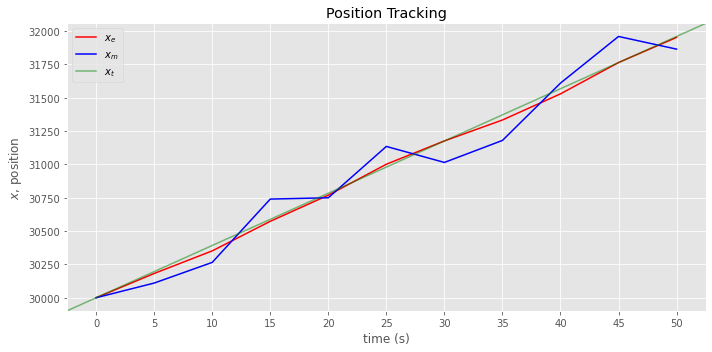

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

_ = data.pos_e.plot(kind='line', color='red', label=r'$x_e$', ax=ax)
_ = data.pos_m.plot(kind='line', color='blue', label=r'$x_m$', ax=ax)
_ = ax.plot([0, 1], [0, 1], color='green', label=r'$x_t$', alpha=0.5, transform=ax.transAxes)
_ = ax.set_xticks(data.index)
_ = ax.set_xticklabels(data.index)
_ = ax.legend()
_ = ax.set_xlabel('time (s)')
_ = ax.set_ylabel(r'$x$, position')
_ = ax.set_title('Position Tracking')

plt.tight_layout()

Here, we plot the estimated $v_e$ and true $v_t$ velocities over time.

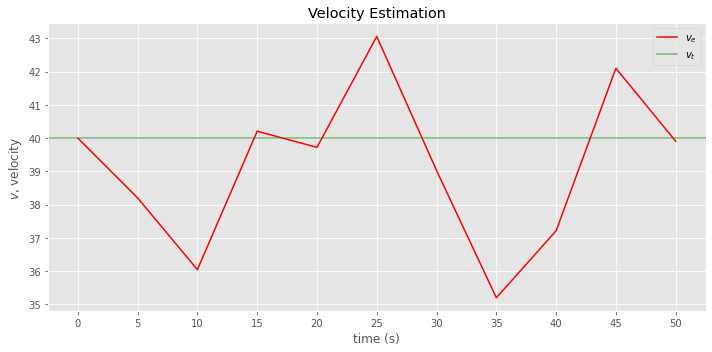

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

_ = data.vel_e.plot(kind='line', color='red', label=r'$v_e$', ax=ax)
_ = ax.axhline(40, color='green', alpha=0.5, label=r'$v_t$')
_ = ax.set_xticks(data.index)
_ = ax.set_xticklabels(data.index)
_ = ax.legend()
_ = ax.set_xlabel('time (s)')
_ = ax.set_ylabel(r'$v$, velocity')
_ = ax.set_title('Velocity Estimation')

plt.tight_layout()

Let's simulate position data according to the following.

$x_{n+1,n} = x_{n,n} + \Delta{t} \mathcal{N}(40, 2.4)$

In [9]:
dt = 5
t = np.arange(0, 200 + dt, dt)
N = len(t)

pos = [30000]
vel = [40]

for n in range(N):
    p = pos[n] + dt * vel[n]
    v = np.random.normal(40, 2.4)
    pos.append(p)
    vel.append(v)

Now, let's apply the State Extrapolation and Updating Equations to estimate the positions.

In [10]:
mea = pos
data = []
itr = []

a = 0.2
b = 0.1
t = 5

# initialization
p_ii = 30000
v_ii = 40

# State Extrapolation Equations
p_ji = p_ii + t * v_ii
v_ji = v_ii

itr.append(0)
data.append({'pos_e': p_ii, 'vel_e': v_ii, 'pos_p': p_ji, 'vel_p': v_ji, 'pos_m': p_ii})

for i, z_i in enumerate(mea):
    # State Update Equations
    p_ii = p_ji + a * (z_i - p_ji)
    v_ii = v_ji + b * (z_i - p_ji) / t
    
    # State Extrapolation Equations
    p_ji = p_ii + t * v_ii
    v_ji = v_ii
    
    time = t * (i + 1)
    itr.append(time)
    
    data.append({'pos_e': p_ii, 'vel_e': v_ii, 'pos_p': p_ji, 'vel_p': v_ji, 'pos_m': z_i})
    
data = pd.DataFrame(data, index=itr)

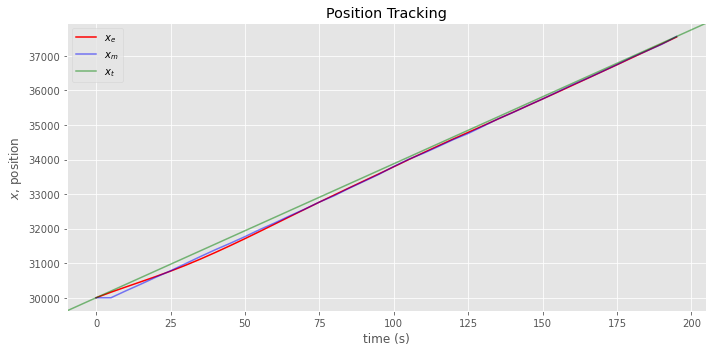

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

_ = data[data.index < 200].pos_e.plot(kind='line', color='red', label=r'$x_e$', ax=ax)
_ = data[data.index < 200].pos_m.plot(kind='line', color='blue', label=r'$x_m$', alpha=0.5, ax=ax)
_ = ax.plot([0, 1], [0, 1], color='green', label=r'$x_t$', alpha=0.5, transform=ax.transAxes)
_ = ax.legend()
_ = ax.set_xlabel('time (s)')
_ = ax.set_ylabel(r'$x$, position')
_ = ax.set_title('Position Tracking')

plt.tight_layout()

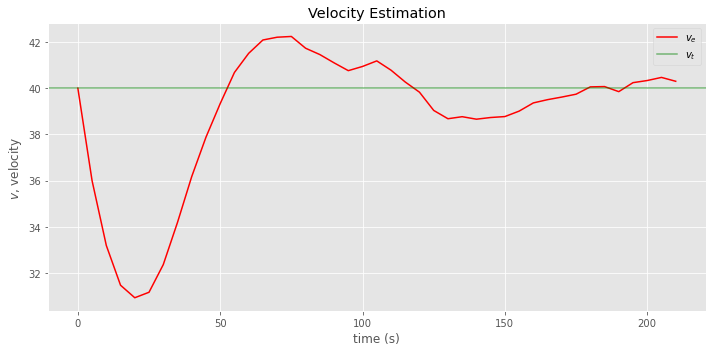

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

_ = data.vel_e.plot(kind='line', color='red', label=r'$v_e$', ax=ax)
_ = ax.axhline(40, color='green', alpha=0.5, label=r'$v_t$')
_ = ax.legend()
_ = ax.set_xlabel('time (s)')
_ = ax.set_ylabel(r'$v$, velocity')
_ = ax.set_title('Velocity Estimation')

plt.tight_layout()

## Tracking aircraft, changing velocity and acceleration

In the [third example](https://www.kalmanfilter.net/alphabeta.html#ex3), the position of an aircraft with changing velocity and acceleration is tracked using the model in second example. This example serves to illustrate that if a model does not correctly capture the dynamics, then **lag error** results. The **lag error** goes by many names.

- Dynamic error
- Systematic error
- Bias error
- Truncation error

These are the true values of acceleration, velocity and position.

In [13]:
tim = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
acc = [0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8]
vel = [50, 50, 50, 50, 90, 130, 170, 210, 250, 290, 330]
pos = [30000, 30250, 30500, 30750, 31200, 31850, 32700, 33750, 35000, 36450, 38100]

acc = pd.Series(acc, index=tim)
vel = pd.Series(vel, index=tim)
pos = pd.Series(pos, index=tim)

Now we take measurements and make estimations.

In [14]:
mea = [30160, 30365, 30890, 31050, 31785, 32215, 33130, 34510, 36010, 37265]
data = []
itr = []

a = 0.2
b = 0.1
t = 5

# initialization
p_ii = 30000
v_ii = 50

# State Extrapolation Equations
p_ji = p_ii + t * v_ii
v_ji = v_ii

itr.append(0)
data.append({'pos_e': p_ii, 'vel_e': v_ii, 'pos_p': p_ji, 'vel_p': v_ji, 'pos_m': p_ii})

for i, z_i in enumerate(mea):
    # State Update Equations
    p_ii = p_ji + a * (z_i - p_ji)
    v_ii = v_ji + b * (z_i - p_ji) / t
    
    # State Extrapolation Equations
    p_ji = p_ii + t * v_ii
    v_ji = v_ii
    
    time = t * (i + 1)
    itr.append(time)
    
    data.append({'pos_e': p_ii, 'vel_e': v_ii, 'pos_p': p_ji, 'vel_p': v_ji, 'pos_m': z_i})
    
data = pd.DataFrame(data, index=itr)
data

,pos_e,vel_e,pos_p,vel_p,pos_m
0,30000.000000,50.000000,30250.000000,50.000000,30000
5,30232.000000,48.200000,30473.000000,48.200000,30160
10,30451.400000,46.040000,30681.600000,46.040000,30365
15,30723.280000,50.208000,30974.320000,50.208000,30890
20,30989.456000,51.721600,31248.064000,51.721600,31050
25,31355.451200,62.460320,31667.752800,62.460320,31785
30,31777.202240,73.405264,32144.228560,73.405264,32215
35,32341.382848,93.120693,32806.986312,93.120693,33130
40,33147.589050,127.180967,33783.493882,127.180967,34510
45,34228.795106,171.711089,35087.350550,171.711089,36010


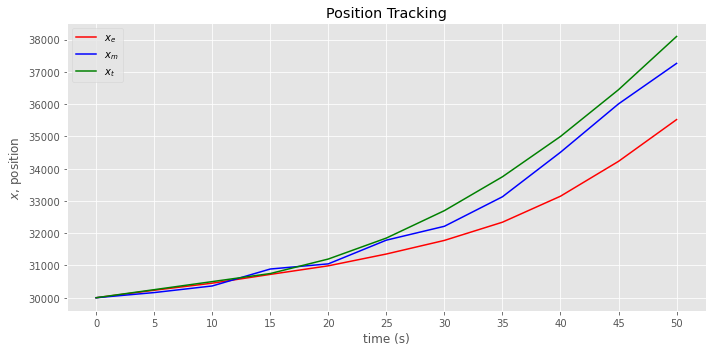

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

_ = data.pos_e.plot(kind='line', color='red', label=r'$x_e$', ax=ax)
_ = data.pos_m.plot(kind='line', color='blue', label=r'$x_m$', ax=ax)
_ = pos.plot(kind='line', color='green', label=r'$x_t$', ax=ax)
_ = ax.set_xticks(data.index)
_ = ax.set_xticklabels(data.index)
_ = ax.legend()
_ = ax.set_xlabel('time (s)')
_ = ax.set_ylabel(r'$x$, position')
_ = ax.set_title('Position Tracking')

plt.tight_layout()

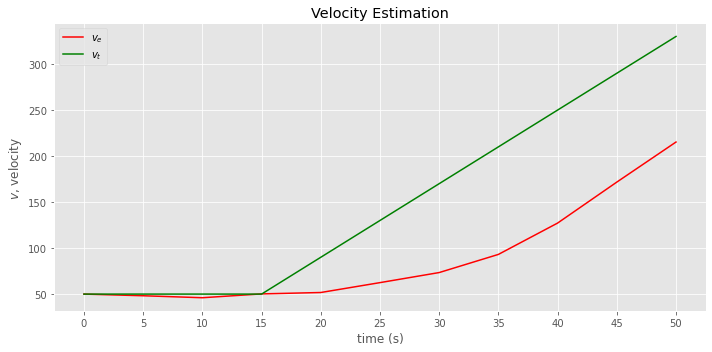

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

_ = data.vel_e.plot(kind='line', color='red', label=r'$v_e$', ax=ax)
_ = vel.plot(kind='line', color='green', label=r'$v_t$', ax=ax)
_ = ax.set_xticks(data.index)
_ = ax.set_xticklabels(data.index)
_ = ax.legend()
_ = ax.set_xlabel('time (s)')
_ = ax.set_ylabel(r'$v$, velocity')
_ = ax.set_title('Velocity Estimation')

plt.tight_layout()

## Tracking aircraft, $\alpha$ - $\beta$ - $\gamma$ filter

To properly track the aircraft, our model must consider the changing acceleration. We should use the $\alpha$ - $\beta$ - $\gamma$ filter (or, `g-h-k filter`). The State Extrapolation Equations are given as follows.

- $\hat{x}_{n+1,n} = \hat{x}_{n,n} + \hat{v}_{n,n} \Delta{t} + \hat{a}_{n,n} \frac{\Delta t^2}{2}$
- $\hat{v}_{n+1,n} = \hat{v}_{n,n} + \hat{a} \Delta t$
- $\hat{a}_{n+1,n} = \hat{a}_{n,n}$

The State Update Equations are given as follows.

- $\hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha \Delta x$
- $\hat{v}_{n,n} = \hat{v}_{n,n-1} + \beta \frac{ \Delta x}{ \Delta t}$
- $\hat{a}_{n,n} = \hat{a}_{n,n-1} + \gamma \frac{ \Delta x}{0.5  \Delta t^2}$